# Projet 10 : Détectez des faux billets avec R ou Python

# Partie 3

La partie 4 contient la régression logistique, utilisée pour différencier vrais et faux billets. On commencera par réaliser le modèle de régression logistique. Puis on cherchera à comparer le taux de vrais et de faux positifs. Enfin on procédera à la mise en place de l'algorithme.

# Sommaire
* [Importation des librairies](#Importation_des_librairies)
* [Importation des données](#Importation_des_données)
* [Régression logistique](#régression_logistique)
    * [Matrice de confusion](#matrice_de_confusion)
    * [Coefficient des features](#coefficient_des_features)
    * [TFP vs TVP](#tfp_vs_tvp)
* [Algorithme](#Algorithme)

## Importations des libraires<a class="anchor" id="Importation_des_librairies"></a>

In [1]:
# Importation des librairies

# Mulitpurpose
import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

# Régression logistique
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

## Importation des données<a class="anchor" id="Importation_des_données"></a>

In [2]:
# Importation des données
billets_data_3 =  pd.read_csv("billets_data_3.csv", sep=",")
billets_production =  pd.read_csv("billets_production.csv", sep=",")

## Régression logistique<a class="anchor" id="régression_logistique"></a>

In [3]:
# Regression logistique avec SKlearn
# On défini les valeurs caractéristiques et la valeur cible
x = billets_data_3[["diagonal","height_left","height_right","margin_low","margin_up","length"]]
y = billets_data_3["is_genuine"]

# Fractionnage en données d'entraînement/données test 75/25
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0)

# Création du modèle
modele_regLog = skl.LogisticRegression(random_state = 0, solver = 'liblinear', multi_class = 'auto')

# Entraînement
modele_regLog.fit(x_train,y_train)

# Calcule de la précision du modèle
precision = modele_regLog.score(x_test,y_test)
print("R²:",precision)

R²: 0.992


### Matrice de Confusion<a class="anchor" id="matrice_de_confusion"></a>

In [4]:
conf = confusion_matrix(y_test, modele_regLog.predict(x_test),normalize="pred")
mcf = pd.DataFrame(data=conf, columns=["Faux billets", "Vrais billets"])
mcf.index = ["Prédit Faux", "Prédit Vrai"]
round(mcf*100,2)

,Faux billets,Vrais billets
Prédit Faux,98.43,0.4
Prédit Vrai,1.57,99.6


### Coefficient des features<a class="anchor" id="coefficient_des_features"></a>

In [5]:
# Affiche les coefficients des features, plus le coefficient est élevé plus la feature est impactante
coefs=1/np.exp(modele_regLog.coef_[0])
coefs[5]=1/coefs[5]
pd.DataFrame(data=coefs,
             index=x_train.columns,
             columns=["Coefs"])

,Coefs
diagonal,1.020784
height_left,5.005972
height_right,8.016661
margin_low,25.488422
margin_up,26.124542
length,39.343970


### TFP vs TVP<a class="anchor" id="tfp_vs_tvp"></a>

In [6]:
# Calcule le taux de faux positifs et de vrais positifs en fonction du seuil
probas = modele_regLog.predict_proba(x_test)
fpr0, tpr0, thresholds0 = roc_curve(y_test, probas[:, 0], pos_label=modele_regLog.classes_[0], drop_intermediate=False)
dftp = pd.DataFrame(dict(TFP=fpr0, TVP=tpr0, threshold=thresholds0)).copy()
dftp.head(n=2)

,TFP,TVP,threshold
0,0.0,0.000000,1.999999
1,0.0,0.007937,0.999999


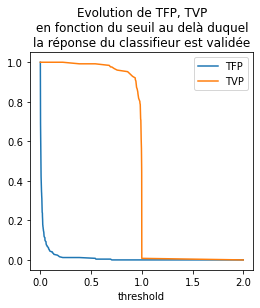

In [7]:
# Affiche le taux de faux positifs et de vrais positifs en fonction du seuil
ax = dftp.plot(x="threshold", y=['TFP', 'TVP'], figsize=(4, 4))
ax.set_title("Evolution de TFP, TVP\nen fonction du seuil au delà duquel\n" +
             "la réponse du classifieur est validée");

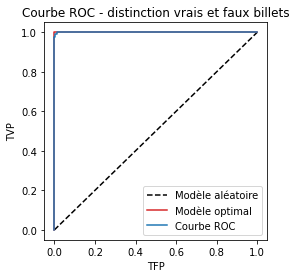

In [8]:
# Courbe ROC qui nous indique le rapport entre le taux de vrais et de faux positifs
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--', label="Modèle aléatoire")
plt.plot([0, 0, 0, 1], [0, 0.1, 1, 1], c="tab:red", label="Modèle optimal")
aucf = roc_auc_score(y_test == modele_regLog.classes_[0], probas[:, 0])
ax.plot(fpr0, tpr0, label="Courbe ROC", c="tab:blue")
ax.set_title('Courbe ROC - distinction vrais et faux billets')
ax.set_xlabel("TFP")
ax.legend()
ax.set_ylabel("TVP");

## Algorithme<a class="anchor" id="Algorithme"></a>

In [9]:
# Algorithme de détection des faux billets qui prend en entrée un DataFrame contenant les colonnes :
# 'diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up','length'
# L'algorithme retourne un dataframe contenant les résultats
def detection_billet(data):
    # Créé un nouveau DataFrame et récupère les données nécessaires du DataFrame entré pour éliminer les colonnes superflues
    tab = pd.DataFrame()
    tab["diagonal"] = data["diagonal"]
    tab["height_left"] = data["height_left"]
    tab["height_right"] = data["height_right"]
    tab["margin_low"] = data["margin_low"]
    tab["margin_up"] = data["margin_up"]
    tab["length"] = data["length"]
    tab2 = data
    # Lance la prédiction
    tab2["predict"]=modele_regLog.predict(tab)
    tab2["proba false"]=modele_regLog.predict_proba(tab)[:,0].round(4)*100
    tab2["proba true"]=modele_regLog.predict_proba(tab)[:,1].round(4)*100
    return(tab2)

In [10]:
detection_billet(billets_production)

,diagonal,height_left,height_right,margin_low,margin_up,length,id,predict,proba false,proba true
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False,99.36,0.64
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False,99.87,0.13
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False,99.86,0.14
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True,9.03,90.97
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True,0.05,99.95


L'algorithme de détection des billets a été mis en place, il requiert en entrée un dataframe contenant les colonnes diagonal, height_left, height_right, margin_low, margin_up et length, précisemment orthographiées comme ceci. Il retourne le DataFrame entré avec une colonne supplémentaire, cluster, qui indique si les billets sont vrais ou faux.